# Spatial Analysis and Modeling

### Instructor: Rossano Schifanella
Email: [rossano.schifanella@unito.it](mailto:rossano.schifanella@unito.it)

## Represent Spatial Data

## Exercise 3

In this exercise you will learn how to:
* Use Python to load data from a shapefile, CSV or a GeoJSON datasource
* Perform spatial functions
* Boost the performance: indexing and prepared geometries


### Define basic transformation functions

Basic functions to transform SRID of Point, Polygon or MultiPolygon

In [1]:
from pyproj import Proj, transform

def transform_point(SRID_from, SRID_to, point):
    p_in    = Proj("+init=%s" %SRID_from)
    p_out   = Proj("+init=%s" %SRID_to)
    return transform(p_in, p_out, point[0], point[1])

def transform_polygon(SRID_from, SRID_to, geometry):
    coordinates = []
    for polygon in geometry:
        projected_coordinates = []
        for p in polygon:
            projected_coordinates.append(transform_point(SRID_from, SRID_to, p))
        coordinates.append(projected_coordinates)
    return coordinates

def transform_multipolygon(SRID_from, SRID_to, multipolygon):
    projected_coordinates = []
    for polygon in multipolygon:
        projected_coordinates.append(transform_polygon(SRID_from, SRID_from, polygon))
    return projected_coordinates

### Load data from a shapefile 

Load a shapefile from a local file and create a _shapely_ object for each geometry feature  

In [2]:
from shapely.geometry import *
import fiona

neighborhoods2geometry = {}

with fiona.open('../data/shp/nyc_neighborhoods/nyc_neighborhoods.shp', 'r') as source:
    print("Shapefile CRS = %s" %source.crs['init'])
    for f in source:
        try:
            neighborhoods2geometry[f['properties']['NAME']] = shape(f['geometry'])
        except Exception as ex:
            print(ex)

print("Loaded %d features (attributes: %s)" %(len(neighborhoods2geometry), f['properties'].keys())) 


Shapefile CRS = epsg:26918
Loaded 129 features (attributes: odict_keys(['BORONAME', 'NAME']))


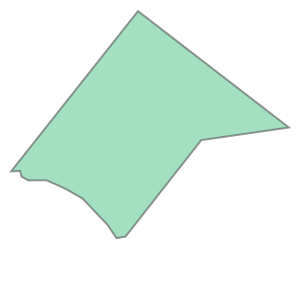

In [3]:
neighborhoods2geometry['Bensonhurst']

### Load crime data

Load crime data from a local CSV file and:

* Transform the original coordinates system (EPSG:4326) to the same SRID used with the neighborhood data (EPSG:26918)
* Create a _shapely_ Point for each crime event
* Save additional information on a crime event


In [ ]:
from shapely.geometry import Point
from datetime import datetime
import csv

crime_data_file = '../data/crime/nyc_crime.csv'

crime_events = []
print("loading crime data from %s..." %crime_data_file)
with open(crime_data_file, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
#       Transform crime event location data from EPSG:4326 to EPSG:26918 SRID (same of the neighborhoods shapefile)  
        projected_coordinates = transform_point("EPSG:4326", "EPSG:26918", (row['longitude'], row['latitude']))
        crime_event_location = Point(projected_coordinates)
        crime_events.append({
            'type': row['Offense'],
            'category': row['Offense Classification'],
            'geom': crime_event_location,
            'date': datetime.strptime(row['Occurrence Date'], '%m/%d/%Y %H:%M:%S %p'),
        })

print("loaded %s crime events." %len(crime_events))


loading crime data from ../data/crime/nyc_crime.csv...


### Perform spatial functions on Python geometry objects

In this section we will describe how to compute the most frequent type of crime and its relative frequency for each neighborhood in New York City. We will consider only 10.000 crime instances due to performance issues in computing the spatial function _within_ without the use of indexes or any other performance improvement. 

In [ ]:
import operator 
import time

neighborhood2crime_distribution = {}

start_time = time.time()
for current in crime_events[:10000]:
    
    crime_type = current['type']

    for neighborhood_name in neighborhoods2geometry: 
        
        neighborhood_geom = neighborhoods2geometry[neighborhood_name]
        
        if current['geom'].within(neighborhood_geom):
            neighborhood2crime_distribution.setdefault(neighborhood_name, {})
            neighborhood2crime_distribution[neighborhood_name].setdefault(crime_type, 0)
            neighborhood2crime_distribution[neighborhood_name][crime_type]+=1
            break

print("Time elapsed: %s seconds\n" % (time.time() - start_time))

for neighborhood_name in neighborhood2crime_distribution:
    most_frequent_crime = max(
                            neighborhood2crime_distribution[neighborhood_name].items(), 
                            key=operator.itemgetter(1))[0]
    n_events_most_frequent_crime = neighborhood2crime_distribution[neighborhood_name][most_frequent_crime]
    total_crimes = sum(neighborhood2crime_distribution[neighborhood_name].values())
    
    print("%25s\t%30s\t%s\t%.2f" %(neighborhood_name, 
                                   most_frequent_crime, 
                                   n_events_most_frequent_crime,
                                   (n_events_most_frequent_crime/total_crimes)*100))




### Speed up the computation with indexes and prepared geometries

To improve the running time of spatial functions (especially if the operation is repeated many times on the same geometry) we can use the following basic strategies:

* Create a rtree index that contains the bounding box of the neighborhood shapes
* Simplify (preserving the topology) the neighborhood shapes
* Create prepared geometries for each simplified neighborhood that greatly improve the performance of repeated spatil operations

Note that with these simple improvements we are able to process the entire crime dataset (>100K events) in almost the same time than the previous example (only 10K istances)

In [ ]:
from shapely.prepared import prep
from rtree import index

# Create an index with the neighborhoods  
idx = index.Index()

id2neigh = {}
neighborhoods2prepared_geometry = {}

start_time = time.time()

for i, neigh in enumerate(neighborhoods2geometry):

    id2neigh[i] = neigh    
    idx.insert(i, neighborhoods2geometry[neigh].bounds)
    neighborhoods2prepared_geometry[neigh] = prep(neighborhoods2geometry[neigh].simplify(0.5, preserve_topology=True))
    
neighborhood2crime_distribution = {}

for current in crime_events:
    
    crime_type = current['type']
    
    for j in idx.intersection(current['geom'].bounds):
        
        if neighborhoods2prepared_geometry[id2neigh[j]].contains(current['geom']):
            neighborhood2crime_distribution.setdefault(id2neigh[j], {})
            neighborhood2crime_distribution[id2neigh[j]].setdefault(crime_type, 0)
            neighborhood2crime_distribution[id2neigh[j]][crime_type]+=1
            break
            
print("Time elapsed: %s seconds\n" % (time.time() - start_time))

for neighborhood_name in neighborhood2crime_distribution:
    most_frequent_crime = max(
                            neighborhood2crime_distribution[neighborhood_name].items(), 
                            key=operator.itemgetter(1))[0]
    n_events_most_frequent_crime = neighborhood2crime_distribution[neighborhood_name][most_frequent_crime]
    total_crimes = sum(neighborhood2crime_distribution[neighborhood_name].values())
    
    print("%25s\t%30s\t%s\t%.2f" %(neighborhood_name, 
                                   most_frequent_crime, 
                                   n_events_most_frequent_crime,
                                   (n_events_most_frequent_crime/total_crimes)*100))

**Q1: _Which is the street in New York City with the highest density of crime? (e.g., the highest concentration of criminal activity w.r.t. its lenght)_**